References:
https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tflite.ipynb

# 1. Clone models from tensorflow & mount google drive

## Clone tf models

In [ ]:
# Support for TF2 models was added after TF 2.3.
# !pip install tf-nightly
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3158, done.
remote: Counting objects: 100% (3158/3158), done.
remote: Compressing objects: 100% (2689/2689), done.
remote: Total 3158 (delta 808), reused 1325 (delta 425), pack-reused 0
Receiving objects: 100% (3158/3158), 33.40 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (808/808), done.


##  Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Install Object Detection API

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1684828 sha256=f9173d68fd9524201f0a775c55150d57b747fa574e6938054aeb3f5f24e3610c
  Stored in directory: /tmp/pip-ephem-wheel-cache-rd26rwhf/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=c196442e076f207e7c9b8ec88c77c183d17a7b28ef6b84e8ae3500b87b01a948
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=90403811c4e3dd6375a2167abc80fb486899a5430d7fd5ba0e6d3ab857651058
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=fa0b23bf3fb88d641b914c85aac5cc4dcbcbac7c2fa7a6444a

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Import necessary libraries

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
# Reinstall any package here, incase they're invalidated by the random runtimes 
!pip uninstall --yes opencv_python_headless 
!pip install opencv-python-headless==4.5.4.60 

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Successfully uninstalled opencv-python-headless-4.5.5.62
     |████████████████████████████████| 47.6 MB 1.7 MB/s 


# 3. Define helper functions

## Define function to convert 4 channel images into 3 channel images

In [ ]:
# The image from dataset contains 4 channels (RGBA)
# We need to convert it to 3 channels (BGR) to fit the input of mobileNet model
import cv2
def convert_4chan_to_3chan(img):
  if len(img.shape) > 2 and img.shape[2] == 4:
      #convert the image from RGBA2RGB
      return cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
  return img
      
def convert_4chan_to_3chan_dir(src_dir,dest_dir):
  if not os.path.exists(dest_dir):
      os.makedirs(dest_dir)

  images = [f for f in os.listdir(src_dir)
      if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]
  print(images)
  for filename in images:
    img = cv2.imread(os.path.join(src_dir,filename))
    img = convert_4chan_to_3chan(img)
    cv2.imwrite(os.path.join(dest_dir,filename),img)

## Define function to load image into numpy array 

In [ ]:
# Load image from image path into numpy array
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Only take RGB images
  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Define non max suppression function

In [ ]:
import numpy as np
#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
    		# loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]


## Define plot detection function

In [ ]:
# Plot the detection using viz_util
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold=0.0):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  # print(boxes)
  # boxes = non_max_suppression_slow(boxes, 0.8)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

## Define load and visualize function (to get a hold of the dataset)

In [ ]:
# Load images and visualize the training dataset
def load_image_and_visualize(train_image_dir):
  train_images_np = []
  for i in range(1, 6):
    image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

  images = [f for f in os.listdir(source)
          if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]
          
  plt.rcParams['axes.grid'] = False
  plt.rcParams['xtick.labelsize'] = False
  plt.rcParams['ytick.labelsize'] = False
  plt.rcParams['xtick.top'] = False
  plt.rcParams['xtick.bottom'] = False
  plt.rcParams['ytick.left'] = False
  plt.rcParams['ytick.right'] = False
  plt.rcParams['figure.figsize'] = [14, 7]

  for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
  plt.show()

## Define split function

In [ ]:
import os
import re
from shutil import copyfile
import argparse
import math
import random

# Iterate the image directory, split the images into train and test by given ratio
# Copy the train image xmls into train folder (and test image xmls into test folder)
def iterate_dir(source, dest, ratio, copy_xml):
    """ usage: 
      Partition dataset of images into training and testing sets
      Require the image and annotation be in the same folder
      Args:
        source: source directory containing both image and annotation
        dest: destination directory of train and test folder
        ratio: ratio of test image (0.1-0.2)
        copy_xml: also copy the xmls
    """
    source = source.replace('\\', '/')
    dest = dest.replace('\\', '/')
    train_dir = os.path.join(dest, 'train')
    test_dir = os.path.join(dest, 'test')

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    images = [f for f in os.listdir(source)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]

    num_images = len(images)
    num_test_images = math.ceil(ratio*num_images)

    for i in range(num_test_images):
        idx = random.randint(0, len(images)-1)
        filename = images[idx]
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(test_dir,xml_filename))
        images.remove(images[idx])

    for filename in images:
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(train_dir, xml_filename))


## Define function to load xml files into dataframe

In [ ]:
# Load xml files into dataframe 
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_df(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


## Define function to normalize bounding boxes

In [ ]:
def normalize_df_bbox(dataframe):
  """
    Normalize a bounding box in a pandas.Dataframe
    Bounding box format must contain [xmin,xmax,ymin,ymax]
  """
  newdataframe = dataframe.copy()
  newdataframe['xmin'] = newdataframe['xmin']/newdataframe['width']
  newdataframe['xmax'] = newdataframe['xmax']/newdataframe['width']
  newdataframe['ymin'] = newdataframe['ymin']/newdataframe['height']
  newdataframe['ymax'] = newdataframe['ymax']/newdataframe['height']
  return newdataframe

# 4. Get kaggle plate dataset

In [ ]:
# Get kaggle API key
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# Download Kaggle dataset
!kaggle datasets download -d andrewmvd/car-plate-detection

 95% 193M/203M [00:05<00:00, 34.3MB/s]
100% 203M/203M [00:05<00:00, 36.1MB/s]


In [ ]:
!rm -rf ./car-plate-detection/
!unzip -d ./car-plate-detection/ car-plate-detection.zip

Archive:  car-plate-detection.zip
  inflating: ./car-plate-detection/annotations/Cars0.xml  
  inflating: ./car-plate-detection/annotations/Cars1.xml  
  inflating: ./car-plate-detection/annotations/Cars10.xml  
  inflating: ./car-plate-detection/annotations/Cars100.xml  
  inflating: ./car-plate-detection/annotations/Cars101.xml  
  inflating: ./car-plate-detection/annotations/Cars102.xml  
  inflating: ./car-plate-detection/annotations/Cars103.xml  
  inflating: ./car-plate-detection/annotations/Cars104.xml  
  inflating: ./car-plate-detection/annotations/Cars105.xml  
  inflating: ./car-plate-detection/annotations/Cars106.xml  
  inflating: ./car-plate-detection/annotations/Cars107.xml  
  inflating: ./car-plate-detection/annotations/Cars108.xml  
  inflating: ./car-plate-detection/annotations/Cars109.xml  
  inflating: ./car-plate-detection/annotations/Cars11.xml  
  inflating: ./car-plate-detection/annotations/Cars110.xml  
  inflating: ./car-plate-detection/annotations/Cars111.xm

In [ ]:
# Print the xmls to make sure we get it right
from bs4 import BeautifulSoup
with open("/content/car-plate-detection/annotations/Cars0.xml") as f:
  data = BeautifulSoup(f.read(),"xml")
data

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>images</folder>
<filename>Cars0.png</filename>
<size>
<width>500</width>
<height>268</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>licence</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>226</xmin>
<ymin>125</ymin>
<xmax>419</xmax>
<ymax>173</ymax>
</bndbox>
</object>
</annotation>

# 5. Split and prepare data

## Convert to 3-channel and split images

In [ ]:
# Put images into the same folder
!cp -a /content/car-plate-detection/annotations/. /content/car-plate-detection/images/

image_dir = "/content/car-plate-detection/images/"
cleaned_image_dir = "/content/car-plate-detection/cleaned_images/"
splitted_dir = "/content/car-plate-detection/splitted/"
!rm -rf /content/car-plate-detection/splitted/
!rm -rf /content/car-plate-detection/cleaned_images/

In [ ]:
# Look here, uncomment the below to re-iterate and divide train and test set. Should be the same
iterate_dir("/content/car-plate-detection/images/","/content/car-plate-detection/splitted",0.1,True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Flags not at the start of the expression '([a-zA-Z0-9\\s_\\\\.\\-\\' (truncated)


In [ ]:
convert_4chan_to_3chan_dir(image_dir,cleaned_image_dir)

['Cars151.png', 'Cars147.png', 'Cars227.png', 'Cars357.png', 'Cars239.png', 'Cars257.png', 'Cars56.png', 'Cars169.png', 'Cars199.png', 'Cars197.png', 'Cars113.png', 'Cars271.png', 'Cars431.png', 'Cars103.png', 'Cars107.png', 'Cars214.png', 'Cars238.png', 'Cars424.png', 'Cars302.png', 'Cars413.png', 'Cars59.png', 'Cars242.png', 'Cars136.png', 'Cars160.png', 'Cars240.png', 'Cars51.png', 'Cars161.png', 'Cars221.png', 'Cars200.png', 'Cars423.png', 'Cars254.png', 'Cars426.png', 'Cars91.png', 'Cars289.png', 'Cars120.png', 'Cars256.png', 'Cars208.png', 'Cars355.png', 'Cars6.png', 'Cars50.png', 'Cars52.png', 'Cars275.png', 'Cars276.png', 'Cars219.png', 'Cars361.png', 'Cars235.png', 'Cars32.png', 'Cars312.png', 'Cars57.png', 'Cars46.png', 'Cars133.png', 'Cars280.png', 'Cars392.png', 'Cars216.png', 'Cars65.png', 'Cars329.png', 'Cars134.png', 'Cars48.png', 'Cars236.png', 'Cars184.png', 'Cars106.png', 'Cars313.png', 'Cars156.png', 'Cars178.png', 'Cars177.png', 'Cars408.png', 'Cars237.png', 'Cars17

## Save the splitted xmls to Drive

In [ ]:
# !cp -R /content/car-plate-detection/splitted/ /content/drive/MyDrive/20211/

## Load splitted xmls from Drive

In [ ]:
# If you don't have access to drive, look above
!cp -R /content/drive/MyDrive/20211/splitted /content/car-plate-detection/

## Load image and annotation into nparrays



In [ ]:
train_df = xml_to_df("/content/car-plate-detection/splitted/train")
test_df = xml_to_df("/content/car-plate-detection/splitted/test")
train_df = normalize_df_bbox(train_df)

In [ ]:
gt_boxes = []
train_images_np = []

# Load bboxes in gt_boxes and images into train_images
for filename in train_df['filename']:
  img_path = os.path.join(cleaned_image_dir,filename)
  train_images_np.append(load_image_into_numpy_array(img_path))

  rows = train_df.loc[train_df['filename'] == filename].iterrows()
  bboxes = []
  for row in rows:
    bboxes.append([row[1]['ymin'], row[1]['xmin'], row[1]['ymax'], row[1]['xmax']])
  
  gt_boxes.append(np.array(bboxes, dtype=np.float32))


# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
car_plate_class_id = 1
num_classes = 1

category_index = {car_plate_class_id: {'id': car_plate_class_id, 'name': 'car_plate'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


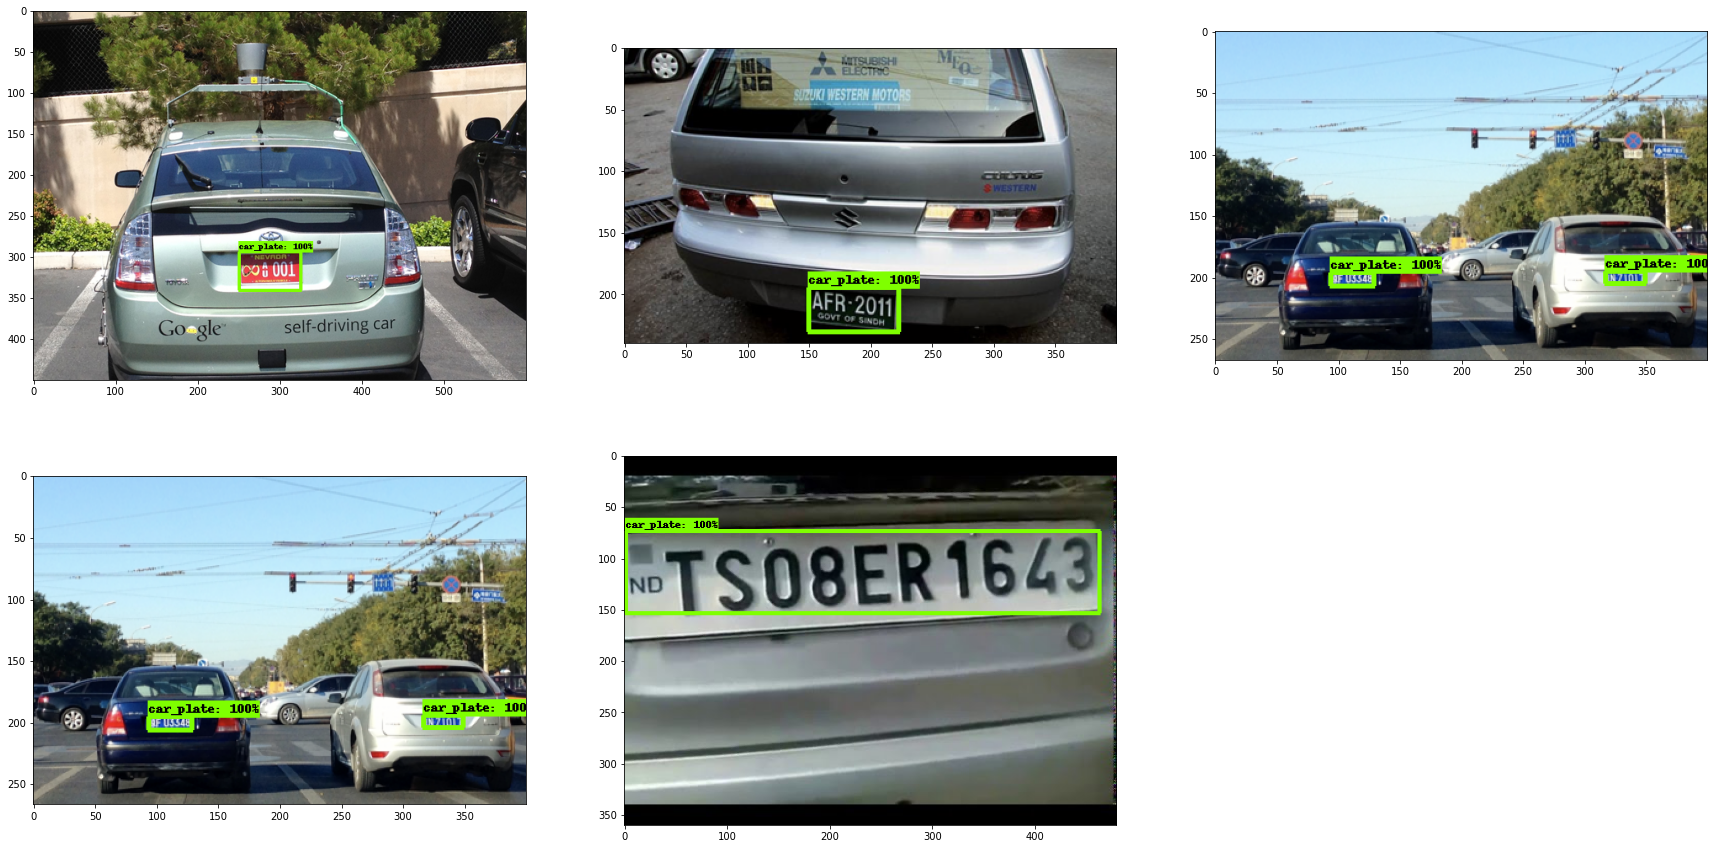

In [ ]:
dummy_scores = np.array([1.0,1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# 6. Get mobilenet weights

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir ./models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-01-12 16:24:18--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.8.128, 2404:6800:4008:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.8.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  48.1MB/s    in 0.4s    

2022-01-12 16:24:19 (48.1 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



# Build model

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
# Checkpoint Restore
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


# 7. Define a train step function (then run the training)

In [ ]:
# Copy checkpoint folder from drive to current folder
!rm -rf output/checkpoint/
!mkdir output/checkpoint/
!cp -R drive/MyDrive/20211/checkpoints/checkpoint/* output/checkpoint/

In [ ]:
tf.keras.backend.set_learning_phase(True)

batch_size = 1
learning_rate = 0.001
num_batches = 1

#Load last checkpoint to train from there
ckpt_manager.restore_or_initialize()

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    # with tf.device('/device:GPU:0'):
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
          for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 1 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

# Copy it to Google drive
# !cp -R output/* drive/MyDrive/20211/checkpoints/

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 1, loss=1.183892
Done fine-tuning!
Checkpoint saved!


# 8. Convert saved model to tflite and do inference 

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# Save the model 
!python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

# Convert model into tflite
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

2022-01-12 16:30:13.143651: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W0112 16:30:24.478507 140046554908544 save_impl.py:72] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7f5e89b72910>, because it is not built.
W0112 16:30:24.642608 140046554908544 save_impl.py:72] Skipping full serialization of Keras layer <keras.layers.convolutional.SeparableConv2D object at 0x7f5e89acebd0>, because it is not built.
W0112 16:30:24.642959 140046554908544 save_impl.py:72] Skipping full serialization of Keras layer <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7f5e89a488d0>, because it is not built.
W0112 16:30:24.643117 140046554908544 save_impl.py:72] Skipping full serialization of Keras layer <keras.layers.core.lambda_layer.Lambda object at 0x7f5e89377f10>, because it is not built.
W0112 16:30:24.643233 1400465

In [ ]:
test_image_dir = 'car-plate-detection/splitted/test/'
cleaned_image_dir = 'car-plate-detection/cleaned_images'
test_images_np = []

for filename in test_df['filename']:
  img_path = os.path.join(cleaned_image_dir,filename)
  test_images_np.append(np.expand_dims(load_image_into_numpy_array(img_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[1]['index'])
  classes = interpreter.get_tensor(output_details[3]['index'])
  scores = interpreter.get_tensor(output_details[0]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

In [ ]:
print(len(test_images_np))

82


In [ ]:
label_id_offset = 1

%rm -rf /content/output_img/
%mkdir /content/output_img/
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)
  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, figsize=(15, 20),
      image_name = "/content/output_img/output_" + str(i) +".png",
      threshold = np.floor(max(max(scores)) * 100)/100)
  

# 9. Download the tflite model (and also the output test images)

In [ ]:
from google.colab import files
# files.download('tflite/model.tflite') 
!rm /content/output_img.zip
!zip -r /content/output_img.zip /content/output_img
files.download('/content/output_img.zip')